### Temas

- Agentes

## Introducción

[**Sugarscape**](http://en.wikipedia.org/wiki/Sugarscape) es un modelo basado en agentes desarrollado por **Joshua M. Epstein** y **Robert Axtell**, presentado originalmente en _Growing Artificial Societies_. Consta de una rejilla 2D, en la que hay un bien abstracto, llamado `azucar`, los agentes vagan por la rejilla y acumulan `azúcar`.

El modelo original es el primer modelo de agentes a gran escala y ocurría en una rejilla de $51 \times 51$ celdas. En cada `step` los agentes miran alredor, encuentran la celda más cercana con `azúcar`, se mueven y metabolizan (tasa a la que consumen `azúcar`). La simulación puede ser complicada y se puede agregar que cada agente deje contaminación, se reproduzca, herede recursos, transfiera información, comercie, regale, transmita enfermedades, o haga la guerra. También es posible agregar un Gobierno que cobre impuestos cada determinado número de `steps` o que inclusive haya dos tipos de bien (en las simulaciones se llama `especia`).

## Preguntas a responder

- Cree un clase `Habitante` que herede de nuestra clase `Agente`, implemente el algoritmo de comportamiento comentado en la introducción. 
- Cree un clase `Sugarscape` que herede de nuestra clase `Mundo`. Representa mediante grados de color la fuerza del agente y la cantidad de azúcar en la celda.
- Cree una clase `Bien` que represente al `azúcar` de **Sugarscape**.
- Ejecuta una simulación sencilla, con agentes consumiendo recursos y acaparándolos. Inicializa los agentes con diferentes capacidades de almacenar azúcar, consumo de azúcar (metabolismo) y rango de visión.
- Grafica la [**curva de Lorenz**](http://en.wikipedia.org/wiki/Lorenz_curve) y el [**coeficiente de Gini**](http://en.wikipedia.org/wiki/Gini_coefficient), grafica también la población y la cantidad de azúcar. ¿Qué interpretación le das a las gráficas?
- Agrega un factor de regeneración del `azúcar`.
- Agrega un factor de reproducción asexual. (Si tiene suficiente energía, se divide en dos).
- Agrega que el agente muera por hambre.
- Agrega la `especia` al modelo, también es necesario para vivir. Su valor nutrimental es diferente al del `azúcar`.
- Agrega la habilidad de comerciar.
- Agrega una `tribu` al agente. 
- Agrega el comportamiento de que nuevos agentes sean creados cuando un agente muera.
- Agrega un tiempo de vida máximo.
- Agrega una variable `sexo`.
- Agrega reproducción sexual (Si está en su edad fértil, ambos tienen energía y le transmiten la mitad a su hijo).

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, clear_output
import inspect, traceback

In [2]:
random.seed(10)

In [3]:
class Agente:
    """ Agente general """
    def __init__(self, tipo, locacion=np.array([0,0])):
        self.tipo = tipo
        self.locacion = locacion
        self.siguiente_accion = None

    def distancia(self, otro):
        "Calcula la distancia euclídea entre este agente y otro."
        return np.linalg.norm(self.locacion - otro.locacion)  # Otra manera es usar np.sqrt(np.sum((a-b)**2))
    
    def vecinos(self, agentes):
        pass
    
    def actuar(self, agentes):
        self.locacion =  self.siguiente_accion
        
    def decidir(self, agentes):
        self.siguiente_accion = np.array([random.uniform(0, 1), random.uniform(0, 1)]) # Toma una nueva posición al azar
    
    def actualizar(self, agentes):
        self.decidir(agentes)
        self.actuar(agentes)

In [4]:
class Mundo:
    def __init__(self, agentes, ancho = 5, alto = 5, steps = 10):
        self.agentes = agentes
        self.ancho = ancho
        self.alto = alto
        self.steps = steps
        self.init_anim()
        
        print ("Creado el mundo")
        
    def init_anim(self):
        self.fig = plt.figure(figsize=(self.ancho, self.alto))
        self.ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
        plot_args = {'markersize' : 8, 'alpha' : 0.6}
        self.puntos, = self.ax.plot([], [], 'o', color='red', **plot_args)
       
       
    def dibujar(self, step):
        x_values_0, y_values_0 = [], []
        for agente in self.agentes:
            x, y = agente.locacion
            x_values_0.append(x)
            y_values_0.append(y)

        self.puntos.set_data(x_values_0, y_values_0)
        
        self.ax.set_title('Paso {}'.format(step))
        
        return self.puntos,
       
    def actualizar(self, step):   
        self.dibujar(step) # Dibuja el mundo
        
        for agente in self.agentes:
            agente.actualizar(self.agentes)
    
    def clean_screen(self):
        self.puntos.set_data([], [])
        return self.puntos,
          
    def simular(self):
        anim = animation.FuncAnimation(self.fig, self.actualizar, init_func=self.clean_screen, frames=self.steps, interval=1000, blit=False)
        return anim


In [5]:
def draw_array(array, **options):

    n, m = array.shape
    plt.axis([-1, m , -1, n])
    return plt.imshow(array, **options)

In [6]:
def decimales(numero):
    if numero == 0:
        return 1
    else:
        return int(70/numero)

### Simulación sencilla

Los agentes nacen ya con sus distintas capacidades. Ningún agente muere por ninguna razón.

In [7]:
class Habitante(Agente):
    
    def __init__(self, tipo, bien):
        Agente.__init__(self, tipo)
        self.bien = bien        

        complete = False 
        
        # Atributos que del agente
        self.capacidad_azucar = random.randint(5,25)
        self.azucar_acumulada = random.randint(3,10)
        self.metabolismo = random.randint(1,4)
        self.rango_vision = random.randint(1,5)
        self.vivo = True        
        
        while(not complete):
            x = int(random.uniform(0, 51))
            y = int(random.uniform(0, 51))
            if(not self.bien.matriz_ocupados[x][y]):
                self.locacion = np.array([x, y])
                self.bien.matriz_ocupados[x][y] = 1
                complete = True
        
    def actuar(self, agentes):
        
        if(not self.vivo):
            return
        
        x = self.locacion[0]
        y = self.locacion[1]
        
        rangos = []
        
        rangos.append((self.bien.matriz_azucar[x][y],x,y))
        
        for i in range(1,self.rango_vision + 1):
            if(x + i >= 51 or self.bien.matriz_ocupados[x + i][y]):
                rangos.append((-1,x+i,y))
            else:
                rangos.append((self.bien.matriz_azucar[x + i][y],x+i,y))
                
            if(y + i >= 51 or self.bien.matriz_ocupados[x][y + i]):
                rangos.append((-1,x,y+i))
            else:
                rangos.append((self.bien.matriz_azucar[x][y + i],x,y+i))
           
            if(x - i < 0 or self.bien.matriz_ocupados[x][y - i]):
                rangos.append((-1,x,y-i))
            else:
                rangos.append((self.bien.matriz_azucar[x][y - i],x,y-i))
        
            if(y - i < 0 or self.bien.matriz_ocupados[x - i][y]):
                rangos.append((-1,x-i,y))
            else:
                rangos.append((self.bien.matriz_azucar[x - i][y],x-i,y))
        
        maxl = lambda x: x[0]
                              
        maxvalue = max(rangos,key=maxl)
        
        coords_max = [(x[1],x[2]) for x in rangos if x[0] == maxvalue[0]]
        
        self.newpos = random.choice(coords_max)
        
        self.locacion = self.newpos
        self.bien.matriz_ocupados[x][y] = 0
        self.bien.matriz_ocupados[self.newpos[0]][self.newpos[1]] = 1
                              
        self.azucar_acumulada += min(maxvalue[0], self.capacidad_azucar)
        self.azucar_acumulada -= self.metabolismo
        
        self.bien.matriz_azucar[self.newpos[0]][self.newpos[1]] = 0


    def actualizar(self, agentes):
        if self.vivo:
            self.actuar(agentes)
            

In [8]:
class Bien():
    
    def __init__(self,x=51 ,y=51):
        
        self.matriz_ocupados = np.zeros(2601).reshape(51,51)
        self.matriz_azucar = np.ones(2601).reshape(51,51)
        for i in range(0,len(self.matriz_azucar)):
            for j in range(0,len(self.matriz_azucar[0])):
                self.matriz_azucar[i][j] = decimales(i + j)
        self.matriz_rate = np.zeros(2601).reshape(51,51)  
    

In [9]:
class Sugarscape(Mundo):
    
    def __init__(self, agentes, bien, ancho = 6, alto = 6, steps = 10):
        self.agentes = agentes
        self.bien = bien
        self.ancho = ancho
        self.alto = alto
        self.steps = steps
        self.init_anim()
        self.draw()

        print ("Creado el mundo")
    
    def animate(self):
        self.draw()
        plt.show()
        clear_output(wait = True)
        
    def draw(self):
        draw_array(self.bien.matriz_azucar, cmap = 'YlOrRd', vmax = 9, origin = 'lower') 
        
    def init_anim(self):
        self.fig = plt.figure(figsize=(self.ancho, self.alto))
        self.ax = plt.axes(xlim=(0, 51), ylim=(0, 51))
        plot_args = {'markersize' : 8, 'alpha' : 0.6}
        self.puntos, = self.ax.plot([], [], 'o', color = 'black', **plot_args)

    def dibujar(self, step):
        x_values_0, y_values_0 = [], []
        for agente in self.agentes:
            x, y = agente.locacion
            x_values_0.append(x)
            y_values_0.append(y)

        self.puntos.set_data(x_values_0, y_values_0)
        
        self.ax.set_title('Paso {}'.format(step))


        return self.puntos,
       
    def actualizar(self, step):         
        self.dibujar(step) # Dibuja el mundo

        for agente in self.agentes:
            agente.actualizar(self.agentes)
        self.animate()
                        
    def clean_screen(self):
        self.puntos.set_data([], [])
        return self.puntos,
          
    def simular(self):
        anim = animation.FuncAnimation(self.fig, self.actualizar, init_func = self.clean_screen, frames=self.steps, interval=1000, blit=False)

        return anim
    

Creado el mundo


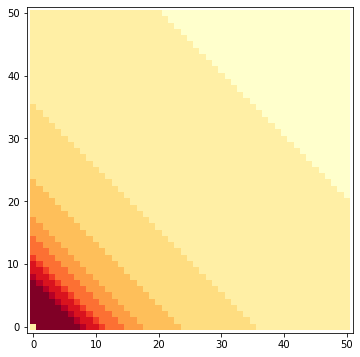

In [10]:
num_agentes = 100
bien_test = Bien()

agentes_azucar = [Habitante(0, bien_test) for i in range(num_agentes)]

con_chiste = Sugarscape(agentes = agentes_azucar, bien = bien_test, steps = 15)


simulacion = con_chiste.simular()

In [11]:
HTML(simulacion.to_html5_video())